In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 0
setup_one_gpu(GPU)

Picking GPU 0


In [2]:
import numpy as np
import os.path as osp
import tensorflow as tf

from general_tools.notebook.tf import reset_tf_graph
from general_tools.in_out import create_dir

from geo_tool import Point_Cloud

from tf_lab.point_clouds.autoencoder import Configuration as Conf
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.convenience import reconstruct_pclouds

from tf_lab.data_sets.shape_net import snc_category_to_synth_id
from tf_lab.iclr.helper import load_multiple_version_of_pcs, find_best_validation_epoch_from_train_stats

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
top_data_dir = '/orions4-zfs/projects/optas/DATA/'

experiment_tag =  'mlp_with_split_1pc_usampled_bnorm_on_encoder_only'

n_pc_points = 2048

random_seed = 42

loss = 'chamfer'

class_name = raw_input('Give me the class type: ').lower()

syn_id = snc_category_to_synth_id()[class_name]

Give me the class type: chair


In [7]:
in_data = load_multiple_version_of_pcs('uniform_one', syn_id, n_classes=1)

679 pclouds were loaded. They belong in 1 shape-classes.
5761 pclouds were loaded. They belong in 1 shape-classes.
338 pclouds were loaded. They belong in 1 shape-classes.


In [8]:
bneck_list = [4, 8, 16, 32, 64, 128, 256, 512]
bneck_list = [128]
for bneck in bneck_list:
    experiment_id = '_'.join(['ae', class_name, experiment_tag, str(n_pc_points), 'pts', str(bneck), 'bneck', loss])
    train_dir = osp.join(top_data_dir, 'OUT/iclr/nn_models/', experiment_id)
    conf = Conf.load(osp.join(train_dir, 'configuration'))
    
    val_error, best_epoch = find_best_validation_epoch_from_train_stats(osp.join(train_dir, 'train_stats.txt'))
    
    if best_epoch % conf.saver_step != 0: # Model was not saved at that epoch: use next bigger epoch.
        epoch_to_load = best_epoch + (best_epoch % conf.saver_step)
    else:
        epoch_to_load = best_epoch
    
    conf.encoder_args['verbose'] = False
    conf.decoder_args['verbose'] = False    
    reset_tf_graph()
    ae = PointNetAutoEncoder(conf.experiment_name, conf)    
    ae.restore_model(conf.train_dir, epoch_to_load, verbose=True)

Model restored in epoch 500.


In [9]:
# _, l_val = reconstruct_pclouds(ae, in_data['val'].point_clouds, batch_size=100)    
# _, l_test = reconstruct_pclouds(ae, in_data['test'].point_clouds, batch_size=100)
# print bneck, l_val, l_test, l_train, best_epoch

# _, l_train = reconstruct_pclouds(ae, in_data['train'].point_clouds, batch_size=100)
reconstructions, losses, feed_data, _, _ = ae.evaluate_one_by_one(in_data['train'], conf)

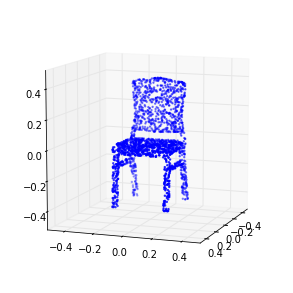

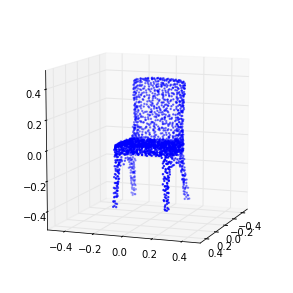

In [59]:
# rid = np.random.randint(len(feed_data))
Point_Cloud(feed_data[rid]).plot(azim =20);
Point_Cloud(reconstructions[rid]).plot(azim=20);

In [11]:
widx = np.argsort(losses)

In [58]:
out_dir = create_dir('/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/iclr/evaluations/failure_cases')

# print losses[widx[-3]]
# Point_Cloud(feed_data[widx[-3]]).plot(azim=20);
# Point_Cloud(reconstructions[widx[-3]]).plot(azim=20);

np.savetxt(osp.join(out_dir,  'style_change_gt.txt'), feed_data[rid])
np.savetxt(osp.join(out_dir, 'style_change_recon.txt'), reconstructions[rid])